<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/LSTM_garret_JAX_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --upgrade pip
%pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html optax flax

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.7/780.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
from functools import partial

In [3]:
## Importação do histórico - UNISIM
df = pd.read_excel('/content/drive/MyDrive/UNISIM/dataset_unisim.xlsx')
df.head()

,t,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
0,0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
1,31,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
2,62,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
3,92,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
4,123,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327


In [4]:
df.shape

(132, 11)

In [5]:
df.index = df['t']
# df.drop('t', axis=1, inplace=True)
df

,t,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
t,,,,,,,,,,,
0,0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
31,31,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
62,62,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
92,92,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
123,123,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327
...,...,...,...,...,...,...,...,...,...,...,...
3867,3867,24757936,2793256452,4393983,36864922,1.398615,0.003554,113.06,0.695071,0.025850,305
3896,3896,25022300,2822363056,4583991,37475894,1.398453,0.003542,113.06,0.692879,0.025905,306
3927,3927,25304090,2853787229,4789676,38123794,1.398291,0.003530,113.06,0.690695,0.025960,307


In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define sequence length and features
window_size = 3  # Number of time steps in each sequence
features_count = len(df.columns) - 1 # t não é considerado como característica

# Separar as características (todas as colunas exceto a última) e o rótulo (última coluna)
features = df.iloc[:, 1:-1]  # Todas as colunas menos a última e a primeira (t)
labels = df.iloc[:, -1]     # Última coluna

# Normalize as características
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Combine as características normalizadas e a coluna de rótulos não normalizada
scaled_data = np.concatenate([scaled_features, labels.values.reshape(-1, 1)], axis=1)
# scaled_data = df.to_numpy()

scaled_data.shape, labels

((132, 10),
 t
 0       332
 31      331
 62      329
 92      328
 123     327
        ... 
 3867    305
 3896    306
 3927    307
 3957    308
 3988    309
 Name: p, Length: 132, dtype: int64)

In [7]:
# Create sequences and corresponding labels
X = []
y = []
for i in range(len(scaled_data) - window_size):
    seq = scaled_data[i:i+window_size]
    label = scaled_data[i+window_size][-1]
    X.append(seq)
    y.append(label)

In [8]:
# Convert to jax numpy arrays
X = jnp.array(X)
y = jnp.array(y)
X.shape, y.shape

((129, 3, 10), (129,))

In [9]:
train_size = int(0.9 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_size, val_size, test_size

(116, 12, 1)

In [10]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
# X_train, X_val, X_test = X, X, X
# y_train, y_val, y_test = y, y, y


X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((116, 3, 10), (116,), (12, 3, 10), (12,), (1, 3, 10), (1,))

In [11]:
X_train[0], y_train[0]

(Array([[-1.1281047e+00, -1.1247137e+00, -5.9374917e-01, -7.5669646e-01,
         -2.1909034e+00, -1.8895059e+00,  1.4210855e-14, -2.0398159e+00,
          2.1909034e+00,  3.3200000e+02],
        [-1.1202886e+00, -1.1170480e+00, -5.9374917e-01, -7.5669646e-01,
         -2.1539545e+00, -1.8648065e+00,  1.4210855e-14, -2.0093000e+00,
          2.1539545e+00,  3.3100000e+02],
        [-1.1124059e+00, -1.1095880e+00, -5.9374917e-01, -7.5669646e-01,
         -2.0800567e+00, -1.8149444e+00,  1.4210855e-14, -1.9479907e+00,
          2.0800567e+00,  3.2900000e+02]], dtype=float32),
 Array(328., dtype=float32))

In [12]:
npp=df["Np"].values[window_size:train_size+window_size]
gp=df["Gp"].values[window_size:train_size+window_size]/1000
wp=df["Wp"].values[window_size:train_size+window_size]
winj=df["Winj"].values[window_size:train_size+window_size]
bo=df["Bo"].values[window_size:train_size+window_size]
bg=df["Bg"].values[window_size:train_size+window_size]
rs=df["Rs"].values[window_size:train_size+window_size]
viso=df["Viso"].values[window_size:train_size+window_size]
visg=df["Visg"].values[window_size:train_size+window_size]
p=df["p"].values[window_size:train_size+window_size]
t=df['t'].values[window_size:train_size+window_size]

In [13]:
p.shape, y_train.shape

((116,), (116,))

In [14]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17
Sor = 0.18
Sgc = 0.05

t0 = df['t'].values[0]
p0 = df["p"].values[0]
Rsi = df["Rs"].values[0]
boi = df["Bo"].values[0]
bgi = df["Bg"].values[0]

t0, p0, Rsi, boi, bgi

(0, 332, 113.06, 1.39424086, 0.003249477045853988)

In [15]:
# Definir a rede LSTM usando Flax
class LSTM(nn.Module):
    @nn.compact
    def __call__(self, x):
        input_shape = x[0].shape

        lstm1 = nn.OptimizedLSTMCell(128)
        lstm2 = nn.OptimizedLSTMCell(64)
        lstm3 = nn.OptimizedLSTMCell(32)

        carry1 = lstm1.initialize_carry(jax.random.PRNGKey(0), input_shape)
        carry2 = lstm2.initialize_carry(jax.random.PRNGKey(0), input_shape)
        carry3 = lstm3.initialize_carry(jax.random.PRNGKey(0), input_shape)

        for i in range(x.shape[0]):
          if i < (x.shape[0] - 1):
            carry1, out1 = lstm1(carry1, x[i])
            carry2, out2 = lstm2(carry2, out1)
            carry3, _ = lstm3(carry3, out2)
          else:
            _, out1 = lstm1(carry1, x[i])
            _, out2 = lstm2(carry2, out1)
            _, x = lstm3(carry3, out2)

        x = nn.Dense(8)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Initialize the random key
rng_key = random.PRNGKey(42)

class LSTMnet(LSTM):
    def setup(self):
        super().setup()
        self.N = self.param("N", jax.nn.initializers.constant(180.0), ())
        self.Wi = self.param("Wi", jax.nn.initializers.constant(100.0), ())
        self.J = self.param("J", jax.nn.initializers.constant(95.0), ())

# Define the Neural Network
model = LSTMnet()

# Initialize the model parameters
rng_key, init_key = random.split(rng_key, 2)
dummy_input = jnp.zeros(X_train[0].shape)
params = model.init(init_key, dummy_input)

## Define the optimizer using Optax
# lr = 0.01
lr = optax.exponential_decay(init_value=1e-3,
                             transition_steps=3000,
                             decay_rate=0.98)
tx = optax.adam(learning_rate=lr)

# Create the training state
state = TrainState.create(
    apply_fn=lambda params_, x_: model.apply(params_, x_)[0],
    # apply_fn=model.apply,
    params=params,
    tx=tx)

# Print the model structure in a fancy way
print(model.tabulate(rng_key, dummy_input))


                                          LSTMnet Summary                                           
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path              ┃ module            ┃ inputs           ┃ outputs           ┃ params            ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│                   │ LSTMnet           │ float32[3,10]    │ float32[1]        │ J: float32[]      │
│                   │                   │                  │                   │ N: float32[]      │
│                   │                   │                  │                   │ Wi: float32[]     │
│                   │                   │                  │                   │                   │
│                   │                   │                  │                   │ 3 (12 B)          │
├───────────────────┼───────────────────┼──────────────────┼───────────────────┼──────────

In [16]:
# Imprimindo os parametros a serem ajustados
state.params['params']['N'], state.params['params']['Wi'], state.params['params']['J']

(Array(180., dtype=float32),
 Array(100., dtype=float32),
 Array(95., dtype=float32))

The solution for u(x=[[-1.1281047e+00 -1.1247137e+00 -5.9374917e-01 -7.5669646e-01
  -2.1909034e+00 -1.8895059e+00  1.4210855e-14 -2.0398159e+00
   2.1909034e+00  3.3200000e+02]
 [-1.1202886e+00 -1.1170480e+00 -5.9374917e-01 -7.5669646e-01
  -2.1539545e+00 -1.8648065e+00  1.4210855e-14 -2.0093000e+00
   2.1539545e+00  3.3100000e+02]
 [-1.1124059e+00 -1.1095880e+00 -5.9374917e-01 -7.5669646e-01
  -2.0800567e+00 -1.8149444e+00  1.4210855e-14 -1.9479907e+00
   2.0800567e+00  3.2900000e+02]] = 0.01183326169848442


Text(0.5, 1.0, 'Previsão antes do ajuste do modelo')

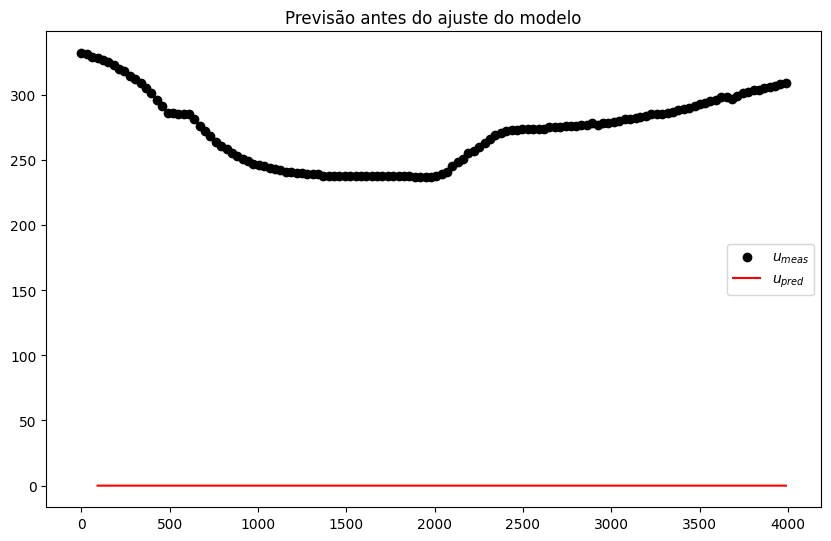

In [17]:
# Avaliando o modelo para um único vetor de entrada
x_single = X_train[0]
u_pred = state.apply_fn(params, x_single)
print(f"The solution for u(x={x_single} = {u_pred}")

# Avaliando a rede neural antes do treinamento considerando todo o histórico
u_pred = vmap(state.apply_fn, (None, 0))(state.params, X)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(df['t'].values, df["p"].values, label=r'$u_{meas}$', color='black')
ax.plot(df["t"].values[window_size:], u_pred, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão antes do ajuste do modelo')

In [18]:
# Definir loss function
@jit
def train_step(state, batch):
    def phy_residual_fn(params, u):
        # Aplicar limites nos parâmetros
        N = jnp.clip(params['params']['N'], 0.0, 300.0)  # Limita N entre 0 e 300
        Wi = jnp.clip(params['params']['Wi'], 100.0, 1000.0)  # Limita Wi entre 100 e 1000
        J = jnp.clip(params['params']['J'], 1.0, 100.0)  # Limita J entre 1 e 100

        #EBM
        rp = gp  / jnp.where(npp != 0, npp, 1.0) * 1000
        F = npp * (bo + (rp-rs) * bg) + (wp - winj) * Bw
        Eo = bo - boi + (Rsi - rs) * bg
        Eg = boi * ((bg / bgi) - 1)
        Efw = (1 + m) * boi * ((cf + cw * Swi)/(1 - Swi)) * (p0 - u)
        We_EBM = F - (N * 10**6) * (Eo + m * Eg + Efw)

        #Aquif
        Wei = (cf + cw) * Wi * p0 * 10**6
        Wen = jnp.zeros(len(t))
        dt = jnp.diff(t)
        dt = jnp.insert(dt, 0, t[0])
        pa_med = jnp.zeros(len(t))
        pa_med = pa_med.at[0].set(p0)
        for i in range(1,len(t)):
          pa_med = pa_med.at[i-1].set(p0 *(1 - (Wen[i-1] / Wei)))
          Wen = Wen.at[i].set(Wen[i-1] + (Wei / p0) * (pa_med[i-1] - u[i]) * (1 - jnp.exp(-J * p0 * dt[i] / Wei)))

        res = (We_EBM - Wen) / 10**6
        # res = 0.0
        return res

    def loss_fn(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        res_pred = phy_residual_fn(params, u_pred)
        phy_loss = jnp.mean(res_pred ** 2) ** 0.5
        data_loss = jnp.mean(jnp.square(u_pred - batch['u']))
        total_loss = 1.0 * data_loss + 10.0 * phy_loss
        return total_loss, {
            "total_loss": total_loss,
            "data_loss": data_loss,
            "phy_loss": phy_loss,
        }

    # Compute the loss and its grads w.r.t. the model parameters
    (_, loss_components), grads = value_and_grad(loss_fn, has_aux=True)(
        state.params, batch
    )
    state = state.apply_gradients(grads=grads)
    return loss_components, state

# Definir evaluation function
@jit
def eval_step(state, batch):
    def eval_error(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        # return jnp.linalg.norm(x=(u_pred - batch['u']), ord=2) / jnp.linalg.norm(x=batch['u'], ord=2)
        return jnp.mean(jnp.square(u_pred - batch['u']))
    return eval_error(state.params, batch)

In [19]:
## TREINAMENTO ##

# Criar logs de treinamento
total_loss_log = []
data_loss_log = []
phy_loss_log = []
epoch_log = []
error_log = []
N_log = []
Wi_log = []
J_log = []

# Criar batches de treinamento e validação
train_batch = {'x': X_train, 'u': y_train}
eval_batch = {'x': X_val, 'u': y_val}

# Criar variável para armazenar o menor erro de validação e o estado correspondente
best_val_error = float('inf')
best_state = None

# Executar o treinamento da rede neural
epochs = 30_000

for epoch in range(epochs):
  loss, state = train_step(state, train_batch)
  if epoch%100 == 0:
    epoch_log.append(epoch)
    N_est = state.params["params"]["N"]
    Wi_est = state.params["params"]["Wi"]
    J_est = state.params["params"]["J"]
    total_loss_log.append(loss['total_loss'])
    data_loss_log.append(loss['data_loss'])
    phy_loss_log.append(loss['phy_loss'])
    eval_error = eval_step(state, eval_batch)
    error_log.append(eval_error)
    N_log.append(N_est)
    Wi_log.append(Wi_est)
    J_log.append(J_est)
    print(f"Epoch: {epoch} -- Total Loss: {loss['total_loss']:0.6f}  -- Data Loss: {loss['data_loss']:0.6f} -- Physics Loss: {loss['phy_loss']:0.6f} -- Error: {eval_error:0.4f} -- N: {N_est:0.2f} -- Wi: {Wi_est:0.2f} -- J: {J_est:0.2f}")

    # Salvar o estado do modelo se o erro de validação for o menor até agora
    if (epoch > 10_000) and (eval_error < best_val_error):
        best_val_error = eval_error
        best_state = state

Epoch: 0 -- Total Loss: 72414.960938  -- Data Loss: 72339.531250 -- Physics Loss: 7.542727 -- Error: 91449.3047 -- N: 180.00 -- Wi: 100.00 -- J: 95.00
Epoch: 100 -- Total Loss: 68850.898438  -- Data Loss: 68777.406250 -- Physics Loss: 7.349438 -- Error: 87394.0312 -- N: 179.90 -- Wi: 99.99 -- J: 94.90
Epoch: 200 -- Total Loss: 64495.492188  -- Data Loss: 64424.414062 -- Physics Loss: 7.107676 -- Error: 82435.3594 -- N: 179.80 -- Wi: 99.99 -- J: 94.80
Epoch: 300 -- Total Loss: 58507.484375  -- Data Loss: 58439.847656 -- Physics Loss: 6.763781 -- Error: 75593.4219 -- N: 179.70 -- Wi: 99.99 -- J: 94.70
Epoch: 400 -- Total Loss: 51099.261719  -- Data Loss: 51036.113281 -- Physics Loss: 6.314754 -- Error: 67069.5625 -- N: 179.61 -- Wi: 99.99 -- J: 94.61
Epoch: 500 -- Total Loss: 42717.664062  -- Data Loss: 42659.992188 -- Physics Loss: 5.767012 -- Error: 57340.0938 -- N: 179.52 -- Wi: 99.99 -- J: 94.52
Epoch: 600 -- Total Loss: 34259.070312  -- Data Loss: 34207.492188 -- Physics Loss: 5.157

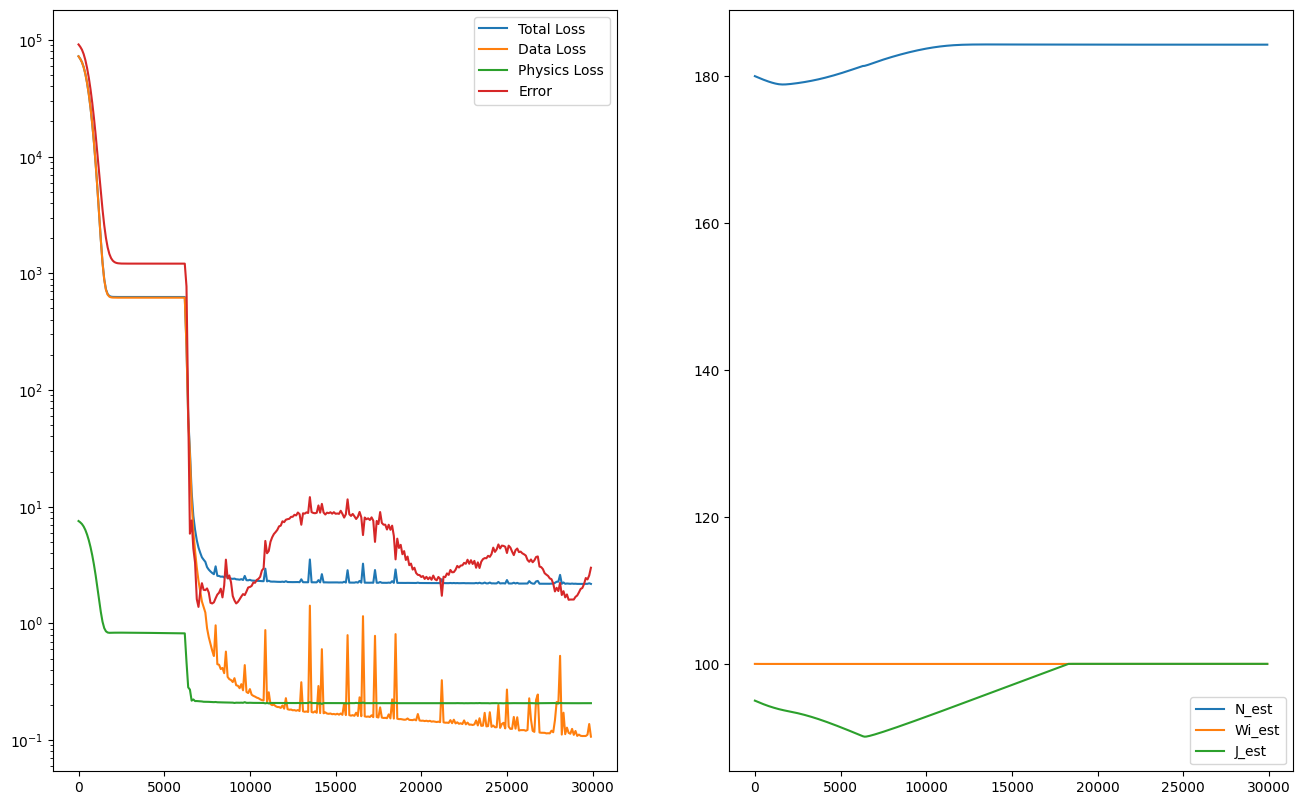

In [20]:
# Plot training & validation loss values
fig, axs = plt.subplots(1, 2, figsize=(16, 16 / 1.618))

axs[0].plot(epoch_log, total_loss_log, label="Total Loss")
axs[0].plot(epoch_log, data_loss_log, label="Data Loss")
axs[0].plot(epoch_log, phy_loss_log, label="Physics Loss")
axs[0].plot(epoch_log, error_log, label="Error")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(epoch_log, N_log, label="N_est")
axs[1].plot(epoch_log, Wi_log, label="Wi_est")
axs[1].plot(epoch_log, J_log, label="J_est")
axs[1].legend()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict using the trained model
predictions = vmap(best_state.apply_fn, (None, 0))(best_state.params, X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 1.334137
Mean Squared Error (MSE): 1.7799214
Root Mean Squared Error (RMSE): 1.334137


In [22]:
# Imprimindo os parametros ajustados
best_state.params['params']['N'], best_state.params['params']['Wi'], best_state.params['params']['J']

(Array(184.2844, dtype=float32),
 Array(99.99402, dtype=float32),
 Array(100.008194, dtype=float32))

Text(0.5, 1.0, 'Previsão depois do ajuste do modelo')

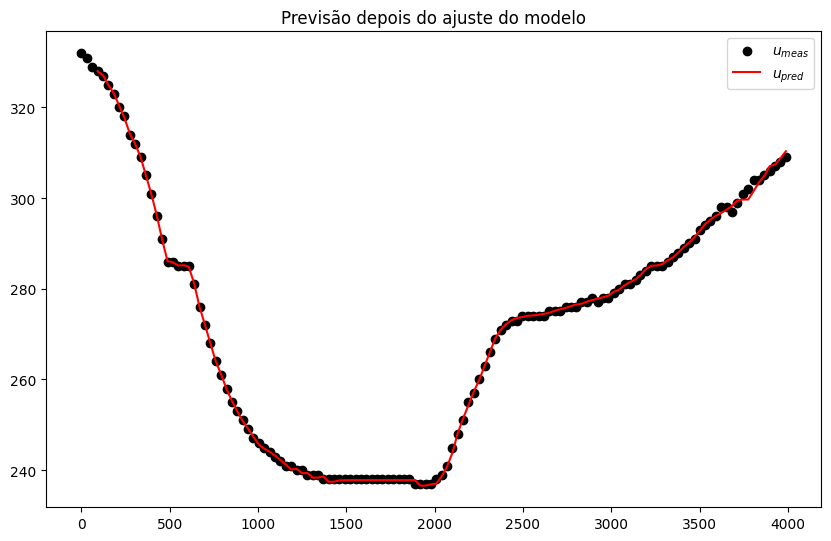

In [23]:
# Avaliando a rede neural depois do treinamento considerando todo o histórico
u_pred = vmap(best_state.apply_fn, (None, 0))(best_state.params, X)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(df['t'].values, df["p"].values, label=r'$u_{meas}$', color='black')
ax.plot(df["t"].values[window_size:], u_pred, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão depois do ajuste do modelo')